In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import torch
torch.set_float32_matmul_precision('medium') # 'medium' or 'high'. Medium is faster

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()



from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Flattening Semifinals
> Which flattening method best preserves the sampling?

Here we compare five methods of neural (and non-neural) flattening, for use in constructing comparison spaces suitable for diffusion curvature.

1. Radial Flattening Autoencoder
2. Radial Flattening Autoencoder + MIOFlow
3. Geodesic Autoencoder + MIOFlow
4. PCA projections of data
5. Uniformly sampled points in $R^n$.

We evaluate these methods by their 'sampling distance' (defined in the Sampling Distance notebook) to the original space. 

These are the 'flattening semifinals' because the *ultimate* test of flattening proficiency is whether a method causes diffusion curvature to perform better than when paired with uniform random noise. *That* hypothesis remains to be evaluated.

**Hypothesis**: 

1. At least *some* methods of flattening will have a lower sampling distance than uniformly sampled data.

# Machinery

The steps here are:

1. Given a collection of manifolds of positive and negative curvature, and varying degrees of curvature, (spheres and hyperboloids), sample N neighborhoods. Add these to a dataframe together with the curvature of the originating region.
2. Run the specified flattening method (encapsulated within a function) on each of these regions.
3. Get the sampling distances between the result and the original space. Add this to another dataframe.

## Create neighborhoods dataset

In [ ]:
from diffusion_curvature.datasets import sphere, rejection_sample_from_saddle
from diffusion_curvature.sampling_distance import *
import pandas as pd
from heatgeo.embedding import HeatGeo

In [ ]:
# compute set of neighborhoods: spheres and saddles
neighbs = []
n_points_per_ds = 500
sphere_radii = [1,2,3,4,5,6,7]
saddle_intensities = [1,2,3,4,5,6,7]
# get spheres
for r in sphere_radii:
    X, ks = sphere(n = 10000, radius = r, use_guide_points=True)
    cap = X[X[:,2] > r-1]
    X_neighborhood = cap[np.concatenate([np.array([0]),np.random.choice(np.arange(1,len(cap)), size=n_points_per_ds)])]
    neighbs.append(
        {
            'X':X_neighborhood,
            'ks':ks[0],
        }
    )

In [ ]:
# get saddles
for r in saddle_intensities:
    X, ks = paraboloid(n=n_points_per_ds, a = r, b = -r,use_guide_points=True)
    neighbs.append(
        {
            'X':X,
            'ks':ks,
        }
    )

In [ ]:
# Compute manifold distances for neighbors
for N in neighbs:
    emb_op = HeatGeo(knn=5)
    emb = emb_op.fit_transform(N['X'])
    N['D'] = emb_op.dist

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


In [ ]:
# convert neighborhoods to dataframe
Neighborhoods = pd.DataFrame(neighbs)

## Baselines

In [ ]:
from diffusion_curvature.radial_flattening_ae import radially_flatten_with_ae

In [ ]:
# Comparisons
from sklearn.decomposition import PCA
def pca_projection(array):
    # Create PCA instance with 2 components
    pca = PCA(n_components=2)
    # Perform PCA on the array
    projected_array = pca.fit_transform(array)
    return projected_array

In [ ]:
def uniform_sampling_of_plane(array):
    return np.random.rand(*array.shape)

## Run Flattening
We'll define this via a function that takes the dataframe as input and returns it with a new column, containing a flattened version of each neighborhood.

In [ ]:
def semifinal_flattener(NBD, flattening_func):
    flattened_spaces = []
    for X in tqdm(NBD['X']):
        flattened_spaces.append(
            flattening_func(X)
        )
    NBD[flattening_func.__name__] = flattened_spaces
    return NBD

In [ ]:
def compute_distances(NBD):
    for flatname in tqdm(NBD.columns[3:]):
        Xs_flattened = NBD[flatname]
        sampling_dists = []
        for i in trange(len(Xs_flattened)):
            X_r = NBD['X'][i]
            X_f = Xs_flattened[i]
            D = NBD['D'][i]
            sampling_dists.append(
                sampling_distance(X_r, X_f, D)
            )
        NBD[flatname + '_dist'] = sampling_dists
    return NBD

## Visualizations

In [ ]:
def visualize_row_of_flattenings(df, i):
    row = df.iloc[i]

    bb = row['X']
    x = row['pca_projection']
    y = row['uniform_sampling_of_plane']
    z = row['radially_flatten_with_ae']
    
    labels = {
        'pca_projection': row['pca_projection_dist'],
        'uniform_sampling_of_plane': row['uniform_sampling_of_plane_dist'],
        'radially_flatten_with_ae': row['radially_flatten_with_ae_dist']
    }
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    
    
    axs[0].scatter(x[:, 0], x[:, 1], c=bb[:,0])
    axs[0].set_title('pca_projection_dist: {}'.format(labels['pca_projection']))
    axs[0].set_xlabel('Dimension 1')
    axs[0].set_ylabel('Dimension 2')
    
    axs[1].scatter(y[:, 0], y[:, 1],c=bb[:,0])
    axs[1].set_title('uniform_sampling_of_plane_dist: {}'.format(labels['uniform_sampling_of_plane']))
    axs[1].set_xlabel('Dimension 1')
    axs[1].set_ylabel('Dimension 2')
    
    axs[2].scatter(z[:, 0], z[:, 1],c=bb[:,0])
    axs[2].set_title('radially_flatten_with_ae_dist: {}'.format(labels['radially_flatten_with_ae']))
    axs[2].set_xlabel('Dimension 1')
    axs[2].set_ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()

# Results

First we'll compute flattened neighborhoods for each of our functions of interest, 
beginning with the two baselines:

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, pca_projection)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, uniform_sampling_of_plane)

  0%|          | 0/14 [00:00<?, ?it/s]

Then our more serious models:

In [ ]:
show_doc(radially_flatten_with_ae)

---

### radially_flatten_with_ae

>      radially_flatten_with_ae (X, D=None, learning_rate=1e-05,
>                                intrinsic_dim=2, return_model=False)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| X |  |  |  |
| D | NoneType | None | if not supplied, computes with heatgeo |
| learning_rate | float | 1e-05 |  |
| intrinsic_dim | int | 2 |  |
| return_model | bool | False |  |

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, radially_flatten_with_ae)

  0%|          | 0/14 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using s_gd2 for MDS. None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


In [ ]:
Neighborhoods = compute_distances(Neighborhoods)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

ValueError: Expected 2D array, got scalar array instead:
array=10.75919693970486.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
Neighborhoods[["ks","pca_projection_dist","radially_flatten_with_ae_dist","uniform_sampling_of_plane_dist"]]

,ks,pca_projection_dist,radially_flatten_with_ae_dist,uniform_sampling_of_plane_dist
0,2.0,10.759197,10.902847,10.999244
1,0.5,10.695422,11.580104,10.981992
2,0.222222,10.720705,11.308413,11.052341
3,0.125,10.544860,11.020262,10.893751
4,0.08,10.627487,11.703726,11.009570
5,0.055556,10.543862,11.188257,10.870823
6,0.040816,10.491760,11.244957,10.940783
7,"[-4.0, -2.738334934065802, -0.7915613745772857...",10.934622,10.918353,11.231274
8,"[-0.25, -0.19613297523381126, -0.1967337719203...",11.067559,10.969923,11.340136
9,"[-0.04938271604938271, -0.042659131904495176, ...",10.960263,10.957130,11.581209


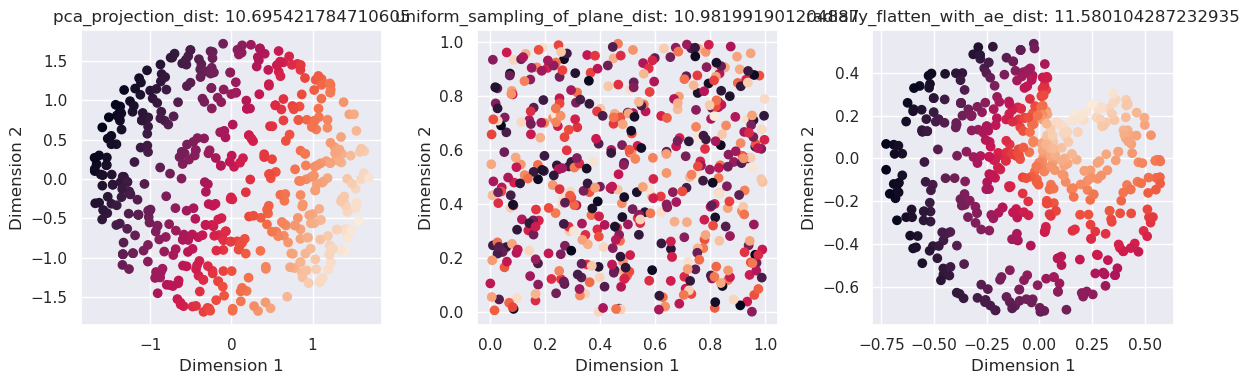

In [ ]:
visualize_row_of_flattenings(Neighborhoods,1)

# Conclusion